In [ ]:
import sys
sys.path.insert(0, '/home/claranunesbarrancos/XAI/CN/peepholelib/')

# torch stuff
import torch
import torchvision
from tensordict import MemoryMappedTensor as MMT

# our stuff
from peepholelib.datasets.cifar import Cifar
from peepholelib.models.model_wrap import ModelWrap 
from peepholelib.coreVectors.coreVectors import CoreVectors 
from peepholelib.peepholes.parsers import trim_corevectors
from peepholelib.peepholes.classifiers.tgmm import GMM as tGMM 
from peepholelib.peepholes.peepholes import Peepholes
from nb_utils import *

# python stuff
import pandas as pd
from pathlib import Path as Path



ModuleNotFoundError: No module named 'peepholelib.classifier.classifier_base'

In [2]:
use_cuda = torch.cuda.is_available()
cuda_index = 0
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(device)

cuda:0


In [ ]:
verbose = True
seed = 42
bs = 512

pretrained = True
dataset = 'CIFAR100' 
seed = 29
bs = 512 

ds_path = '/srv/newpenny/dataset/CIFAR100'

model_dir = '/srv/newpenny/XAI/models'
model_name = 'CN_model=mobilenet_v2_dataset=CIFAR100_optim=Adam_scheduler=RoP_lr=0.001_factor=0.1_patience=5.pth'

svds_path = Path.cwd()/'../data'
svds_name = 'svds' 

cvs_path = Path.cwd()/'../data/data/corevectors'
cvs_name = 'corevectors'

act_path = Path.cwd()/'../data/corevectors'
act_name = 'activations'

drill_path = Path.cwd()/'../data/drillers'
drill_name = 'classifier'

phs_path = Path.cwd()/'../data/data/peepholes'
phs_name = 'peepholes'

cls_path = Path.cwd()/'../data/classifier'
cls_name = 'clustering'

# Dataset

In [4]:
ds = Cifar(
        data_path = ds_path,
        dataset=dataset
        )
ds.load_data(
        batch_size = bs,
        data_kwargs = {'num_workers': 8, 'pin_memory': True},
        seed = seed,
        )

dataset: CIFAR100


# Model

In [ ]:
nn = torchvision.models.mobilenet_v2(pretrained=True)
print(nn.state_dict().keys())

in_features = nn.classifier[-1].in_features
print("in features", in_features)
nn.classifier[-1] = torch.nn.Linear(in_features, len(ds.get_classes()))
model = ModelWrap(
    model=nn,
    path=model_dir,
    name=model_name,
    device=device
    )

model.load_checkpoint(verbose=verbose)

    
target_layers = [ 'features.4.conv.1.0', 'features.5.conv.1.0', 'features.6.conv.1.0', 'features.7.conv.1.0', 'features.8.conv.1.0', 'features.9.conv.1.0', 'features.10.conv.1.0', 
               'features.11.conv.1.0', 'features.12.conv.1.0', 'features.13.conv.1.0', 'features.14.conv.1.0', 'features.15.conv.1.0', 'features.16.conv.1.0', 'features.16.conv.2', 'features.17.conv.0.0']
model.set_target_modules(target_modules=target_layers, verbose=verbose)

/srv/newpenny/conda/envs/xai-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/srv/newpenny/conda/envs/xai-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


odict_keys(['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.conv.0.0.weight', 'features.1.conv.0.1.weight', 'features.1.conv.0.1.bias', 'features.1.conv.0.1.running_mean', 'features.1.conv.0.1.running_var', 'features.1.conv.0.1.num_batches_tracked', 'features.1.conv.1.weight', 'features.1.conv.2.weight', 'features.1.conv.2.bias', 'features.1.conv.2.running_mean', 'features.1.conv.2.running_var', 'features.1.conv.2.num_batches_tracked', 'features.2.conv.0.0.weight', 'features.2.conv.0.1.weight', 'features.2.conv.0.1.bias', 'features.2.conv.0.1.running_mean', 'features.2.conv.0.1.running_var', 'features.2.conv.0.1.num_batches_tracked', 'features.2.conv.1.0.weight', 'features.2.conv.1.1.weight', 'features.2.conv.1.1.bias', 'features.2.conv.1.1.running_mean', 'features.2.conv.1.1.running_var', 'features.2.conv.1.1.num_batches_tracked', 'features.2.conv.2.weight', 'fea

# Corevectors

In [6]:
import numpy as np

o_dnn = {}
o_dnn_dfs = {}

corevecs = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        device = device 
        )

with corevecs as cv:
    cv.load_only(
            loaders = ['train', 'test', 'val'],
            verbose = True
            )

    cv_dl = cv.get_dataloaders(
                batch_size=256,
                verbose=True,
                )

    for split in ['train', 'test', 'val']:
        act_data = cv._actds[split]
        print("act data keys", act_data.keys())
        # Load softmax outputs 
        outputs = act_data['output'][:]  # shape: (n_samples, num_classes)
        #outputs = torch.nn.functional.softmax(torch.tensor(outputs), dim=1).numpy() 

        # Load predicted and true labels
        pred_labels = torch.tensor(act_data['pred'][:])
        true_labels = torch.tensor(act_data['label'][:])
        r = act_data['result'][:].numpy()

        o_dnn[split] = outputs

        # Confidence (max prob) and predicted class
        out_max = np.max(outputs.numpy(), axis=1)  # Correct usage of np.max
        out_label = np.argmax(outputs, axis=1)

        out_df = pd.DataFrame()
        out_df['max'] = out_max
        #out_df['entropy'] = [1 - normalized_entropy(out, adjusted=False) for out in outputs]
        out_df['label'] = out_label
        out_df['true'] = true_labels.numpy().astype(int)
        out_df['result'] = r

        o_dnn_dfs[split] = out_df

        print(f'{split} → outputs shape: {outputs.shape}, df shape: {out_df.shape}')



 ---- Getting data from train

Loading files /srv/newpenny/XAI/CN/XAI/src/../data/data/corevectors/corevectors.train and /srv/newpenny/XAI/CN/XAI/src/../data/data/corevectors/activations.train from disk. 
loaded n_samples:  2000

 ---- Getting data from test

Loading files /srv/newpenny/XAI/CN/XAI/src/../data/data/corevectors/corevectors.test and /srv/newpenny/XAI/CN/XAI/src/../data/data/corevectors/activations.test from disk. 
loaded n_samples:  500

 ---- Getting data from val

Loading files /srv/newpenny/XAI/CN/XAI/src/../data/data/corevectors/corevectors.val and /srv/newpenny/XAI/CN/XAI/src/../data/data/corevectors/activations.val from disk. 
loaded n_samples:  500
creating dataloader for:  train
creating dataloader for:  test
creating dataloader for:  val
act data keys _PersistentTDKeysView(['image', 'in_activations', 'label', 'out_activations', 'output', 'pred', 'result'],
    include_nested=False,
    leaves_only=False)
train → outputs shape: torch.Size([2000, 100]), df shape: 

/tmp/ipykernel_663179/1763301937.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = torch.tensor(act_data['pred'][:])
/tmp/ipykernel_663179/1763301937.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(act_data['label'][:])
/tmp/ipykernel_663179/1763301937.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = torch.tensor(act_data['pred'][:])
/tmp/ipykernel_663179/1763301937.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() 

# Peepholes

In [7]:
cls_type = 'tGMM'
splits = ['train', 'test', 'val']

peephole_config_name = 'peepholes.ps_10.nc_10'
config_names = {'peepholes.ps_10.nc_10'}

In [ ]:
# load scores
peep_layers = [ 'features.4.conv.1.0', 'features.5.conv.1.0', 'features.6.conv.1.0', 'features.7.conv.1.0', 'features.8.conv.1.0', 'features.9.conv.1.0', 'features.10.conv.1.0', 
               'features.11.conv.1.0', 'features.12.conv.1.0', 'features.13.conv.1.0', 'features.14.conv.1.0', 'features.15.conv.1.0', 'features.16.conv.1.0']
n_classes = 100
n_cluster = 100
cv_dim = 10
cls_kwargs = {}
drillers = {}
parser_cv = trim_corevectors


ph_dict = {}

for peep_layer in peep_layers:
        parser_kwargs = {'layer': peep_layer, 'peep_size':cv_dim}

        drillers[peep_layer] = tGMM(
                        path = drill_path,
                        name = drill_name+'.'+peep_layer,
                        nl_classifier = n_cluster,
                        nl_model = n_classes,
                        n_features = cv_dim,
                        parser = parser_cv,
                        parser_kwargs = parser_kwargs,
                        device = device
                        )

        
for ph_config_name in config_names:
    peepholes = Peepholes(
        path = phs_path,
        name = phs_name,
        driller = drillers,
        target_modules = peep_layers,
        device = device
        )
    with peepholes as ph:
        ph.load_only(loaders=splits, verbose=False)
        for split in splits:
            ph_dict.setdefault(ph_config_name, {})[split] = ph._phs[split].detach().cpu()

closing train
closing test
closing val


In [9]:
ph_dict.keys()

dict_keys(['peepholes.ps_10.nc_10'])

In [10]:
ph_dict[peephole_config_name] # inside this we have test, train and val

{'train': TensorDict(
     fields={
         features.10.conv.1.0: TensorDict(
             fields={
                 peepholes: Tensor(shape=torch.Size([2000, 100]), device=cpu, dtype=torch.float32, is_shared=False),
                 score_entropy: Tensor(shape=torch.Size([2000]), device=cpu, dtype=torch.float32, is_shared=False),
                 score_max: Tensor(shape=torch.Size([2000]), device=cpu, dtype=torch.float32, is_shared=False)},
             batch_size=torch.Size([2000]),
             device=cpu,
             is_shared=False),
         features.11.conv.1.0: TensorDict(
             fields={
                 peepholes: Tensor(shape=torch.Size([2000, 100]), device=cpu, dtype=torch.float32, is_shared=False),
                 score_entropy: Tensor(shape=torch.Size([2000]), device=cpu, dtype=torch.float32, is_shared=False),
                 score_max: Tensor(shape=torch.Size([2000]), device=cpu, dtype=torch.float32, is_shared=False)},
             batch_size=torch.Size([2000])

In [11]:
layers = list(ph_dict['peepholes.ps_10.nc_10']['train'].keys())
print("layers:", layers)
n_layers = len(ph_dict['peepholes.ps_10.nc_10']['train'].keys())
print("number of layers: ", n_layers)

layers: ['features.10.conv.1.0', 'features.11.conv.1.0', 'features.12.conv.1.0', 'features.13.conv.1.0', 'features.14.conv.1.0', 'features.15.conv.1.0', 'features.16.conv.1.0', 'features.4.conv.1.0', 'features.5.conv.1.0', 'features.6.conv.1.0', 'features.7.conv.1.0', 'features.8.conv.1.0', 'features.9.conv.1.0']
number of layers:  13


# Conceptograms

In [12]:
# cgs_dict is the dict that contains all conceptograms matrices that we are going to print

cgs_dict = {}
layer = list(ph_dict[peephole_config_name]['train'].keys())[0]

# create the memory mapped tensor dict (pre allocating memory, very mindful)
for key in ph_dict[peephole_config_name].keys():
    cgs_dict[key] = MMT.empty(shape=torch.Size((len(ph_dict[peephole_config_name][key][layer]['peepholes']),)+(len(ph_dict[peephole_config_name]['train'].keys()),)+(n_classes,)))
    print(cgs_dict[key].shape)

torch.Size([2000, 13, 100])
torch.Size([500, 13, 100])
torch.Size([500, 13, 100])


In [13]:
# allocating the actual peepholes in the dictionary

for key in ph_dict[peephole_config_name].keys():
    print(f'\n------------{key}-------------')
    for i,layer in enumerate(target_layers):
        cgs_dict[key][:,i,:] = ph_dict[peephole_config_name][key][layer]['peepholes']
        print(cgs_dict[key][0])


------------train-------------
MemoryMappedTensor([[0.0103, 0.0085, 0.0123,  ..., 0.0075, 0.0135, 0.0108],
                    [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                    ...,
                    [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
MemoryMappedTensor([[0.0103, 0.0085, 0.0123,  ..., 0.0075, 0.0135, 0.0108],
                    [0.0094, 0.0045, 0.0127,  ..., 0.0078, 0.0126, 0.0133],
                    [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                    ...,
                    [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
Memo

In [14]:
peephole_tensor = cgs_dict[split].shape # num samples * num target layers * num classes
print(peephole_tensor)
sample_peephole_map = cgs_dict[split][0].shape # matrix where each row is a layer, each column is a class
print(sample_peephole_map)

torch.Size([500, 13, 100])
torch.Size([13, 100])


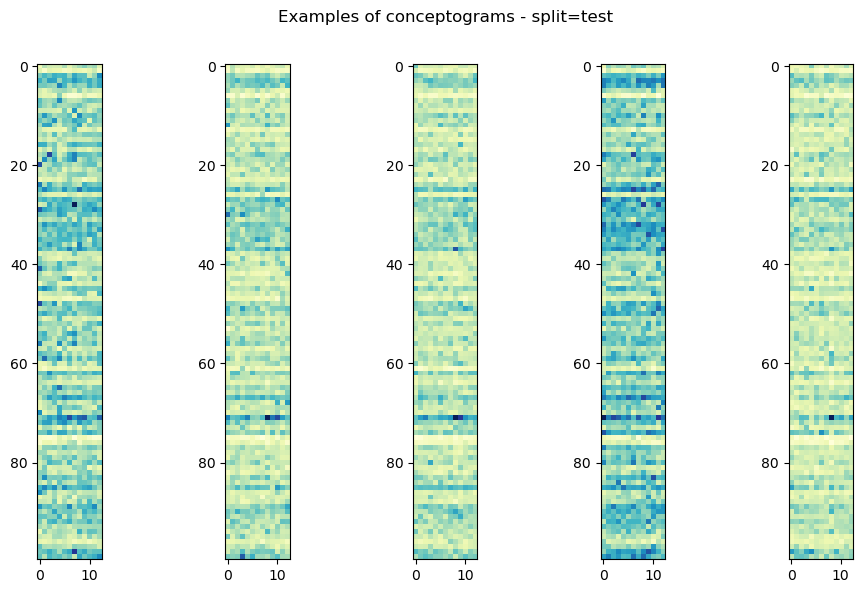

In [ ]:
split = 'test'

n_cgs = 5

fig, axs = plt.subplots(1, n_cgs, figsize=(10, 6))
fig.suptitle(f'Examples of conceptograms - split={split}\n')
for i in range(n_cgs):
    axs[i].imshow(cgs_dict[split][i].detach().cpu().numpy().T, cmap='YlGnBu')
    
plt.tight_layout()

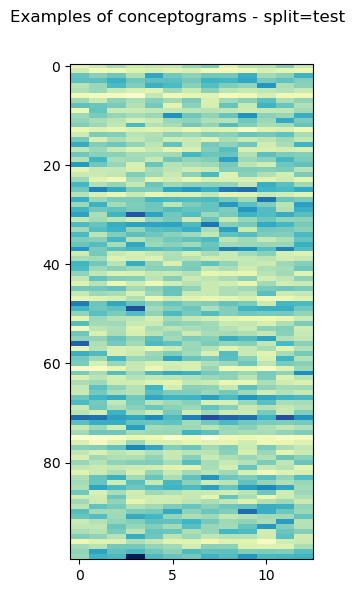

In [16]:
n_cgs = 499

fig, axs = plt.subplots(1, 1, figsize=(3, 6))
fig.suptitle(f'Examples of conceptograms - split={split}\n')
axs.imshow(cgs_dict[split][n_cgs].detach().cpu().numpy().T, aspect='auto', cmap='YlGnBu')
    
plt.tight_layout()

In [17]:
# Assuming o_dnn['test'][sample] is your array
array = o_dnn['test'][0]  # Replace this with your actual data

# Get the maximum value and its position
max_value = torch.max(array).item()  # Use torch.max for PyTorch tensors
max_position = torch.argmax(array).item()  # Use torch.argmax for PyTorch tensors

print(f"Max value: {max_value}")
print(f"Position of max value: {max_position}")

print(o_dnn_dfs['test'])
print("output test keys: ", o_dnn_dfs['test'].keys())

print("-------------------example test-------------------")
print(o_dnn_dfs['test']['label'][0])
print(o_dnn_dfs['test']['true'][0])
print(o_dnn_dfs['test']['result'][0])

# mapping
print(ds._classes[o_dnn_dfs['test']['label'][0]])
print(ds._classes[o_dnn_dfs['test']['true'][0]])
print(ds._classes[o_dnn_dfs['test']['result'][0]])

Max value: 21.822662353515625
Position of max value: 41
           max  label  true  result
0    21.822662     41    41     1.0
1     6.443419     63    63     1.0
2    14.627945     60    60     1.0
3    11.320014      7     7     1.0
4     8.320989     27    29     0.0
..         ...    ...   ...     ...
495   9.574630     90    90     1.0
496   3.168408     33    59     0.0
497  12.319137     77    77     1.0
498  17.573854      9     9     1.0
499  14.810336     95    95     1.0

[500 rows x 4 columns]
output test keys:  Index(['max', 'label', 'true', 'result'], dtype='object')
-------------------example test-------------------
41
41
1.0
lawn_mower
lawn_mower
aquarium_fish


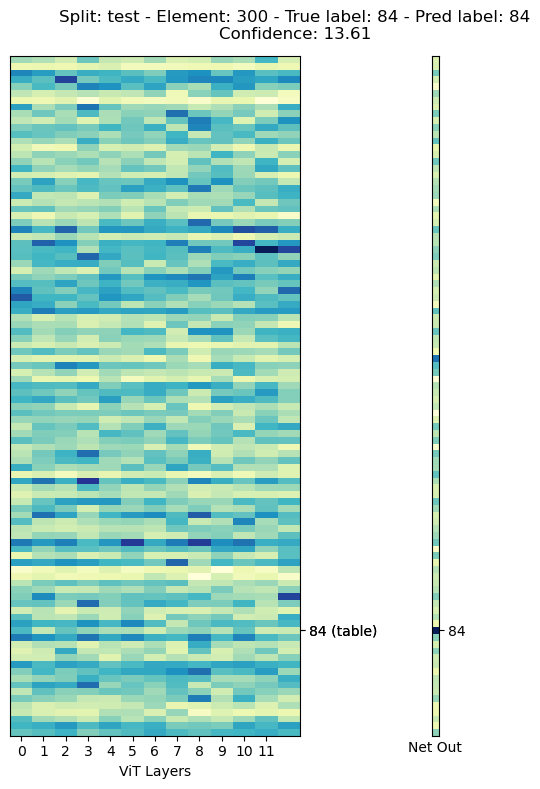

In [18]:
sample = 300

# labels
true_out = o_dnn_dfs[split]['true'][sample]     # number
true_class = ds._classes[true_out]              # string

label_out = o_dnn_dfs[split]['label'][sample]
label_class = ds._classes[label_out]

confidence = o_dnn_dfs[split]['max'][sample]

# matrix and array (print pre label with soft max -> o_dnn)
concepto = cgs_dict[split][sample].detach().cpu().numpy().T
out_net = np.expand_dims(o_dnn[split][sample], axis=1) # roba predetta



fig, ax = plt.subplots(1, 2, figsize=(6, 8))
fig.suptitle(f'Split: {split} - Element: {sample} - True label: {true_out} - Pred label: {label_out}\nConfidence: {confidence:.2f}')

ax[0].imshow(concepto, aspect='auto', cmap='YlGnBu')
ax[0].set_xticks(np.arange(12))
ax[0].set_yticks([true_out, label_out], [f'{true_out} ({true_class})', f'{label_out} ({label_class})'])
ax[0].yaxis.tick_right()
ax[0].set_xlabel('ViT Layers')

ax[1].imshow(out_net, cmap='YlGnBu')
ax[1].set_xticks([])
ax[1].set_yticks([true_out])
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_xlabel('Net Out')

plt.tight_layout()
plt.show()

In [19]:
o_dnn_dfs[split].keys()
rand_samples = []
len(rand_samples)
num = 7
rand_samples.append(7)
rand_samples
rand_samples.append(8)
rand_samples

[7, 8]

In [20]:
i=0
if o_dnn_dfs[split]['max'][i] == confidence:
    print('ciao')

In [21]:
# cycle that prints the first 5 config 

rand_samples = []

cifar_class = 7
result = 0
confidence = 0.9


i = 0
while len(rand_samples) <= 5 and i < 500:
    if o_dnn_dfs[split]['result'][i] == result and o_dnn_dfs[split]['true'][i] == cifar_class:# and o_dnn_dfs[split]['max'][i] >= confidence:
        rand_samples.append(i)
    i = i + 1
print(i)
print(rand_samples)
print(ds._classes[cifar_class])

500
[272, 356, 415]
beetle


In [22]:
rand_samples = [2, 4, 78, 123, 341]

# Sort indices based on confidence values in descending order
sorted_samples = sorted(rand_samples, key=lambda sample: o_dnn_dfs[split]['max'][sample], reverse=True)

print(sorted_samples)

[2, 4, 123, 78, 341]


In [23]:
for i, sample in enumerate(sorted_samples):
    confidence = o_dnn_dfs[split]['max'][sample]
    print(confidence)

14.627945
8.320989
4.870746
2.6513953
1.2697712


otter
Samples found:  [195, 297]
Chosen class: otter


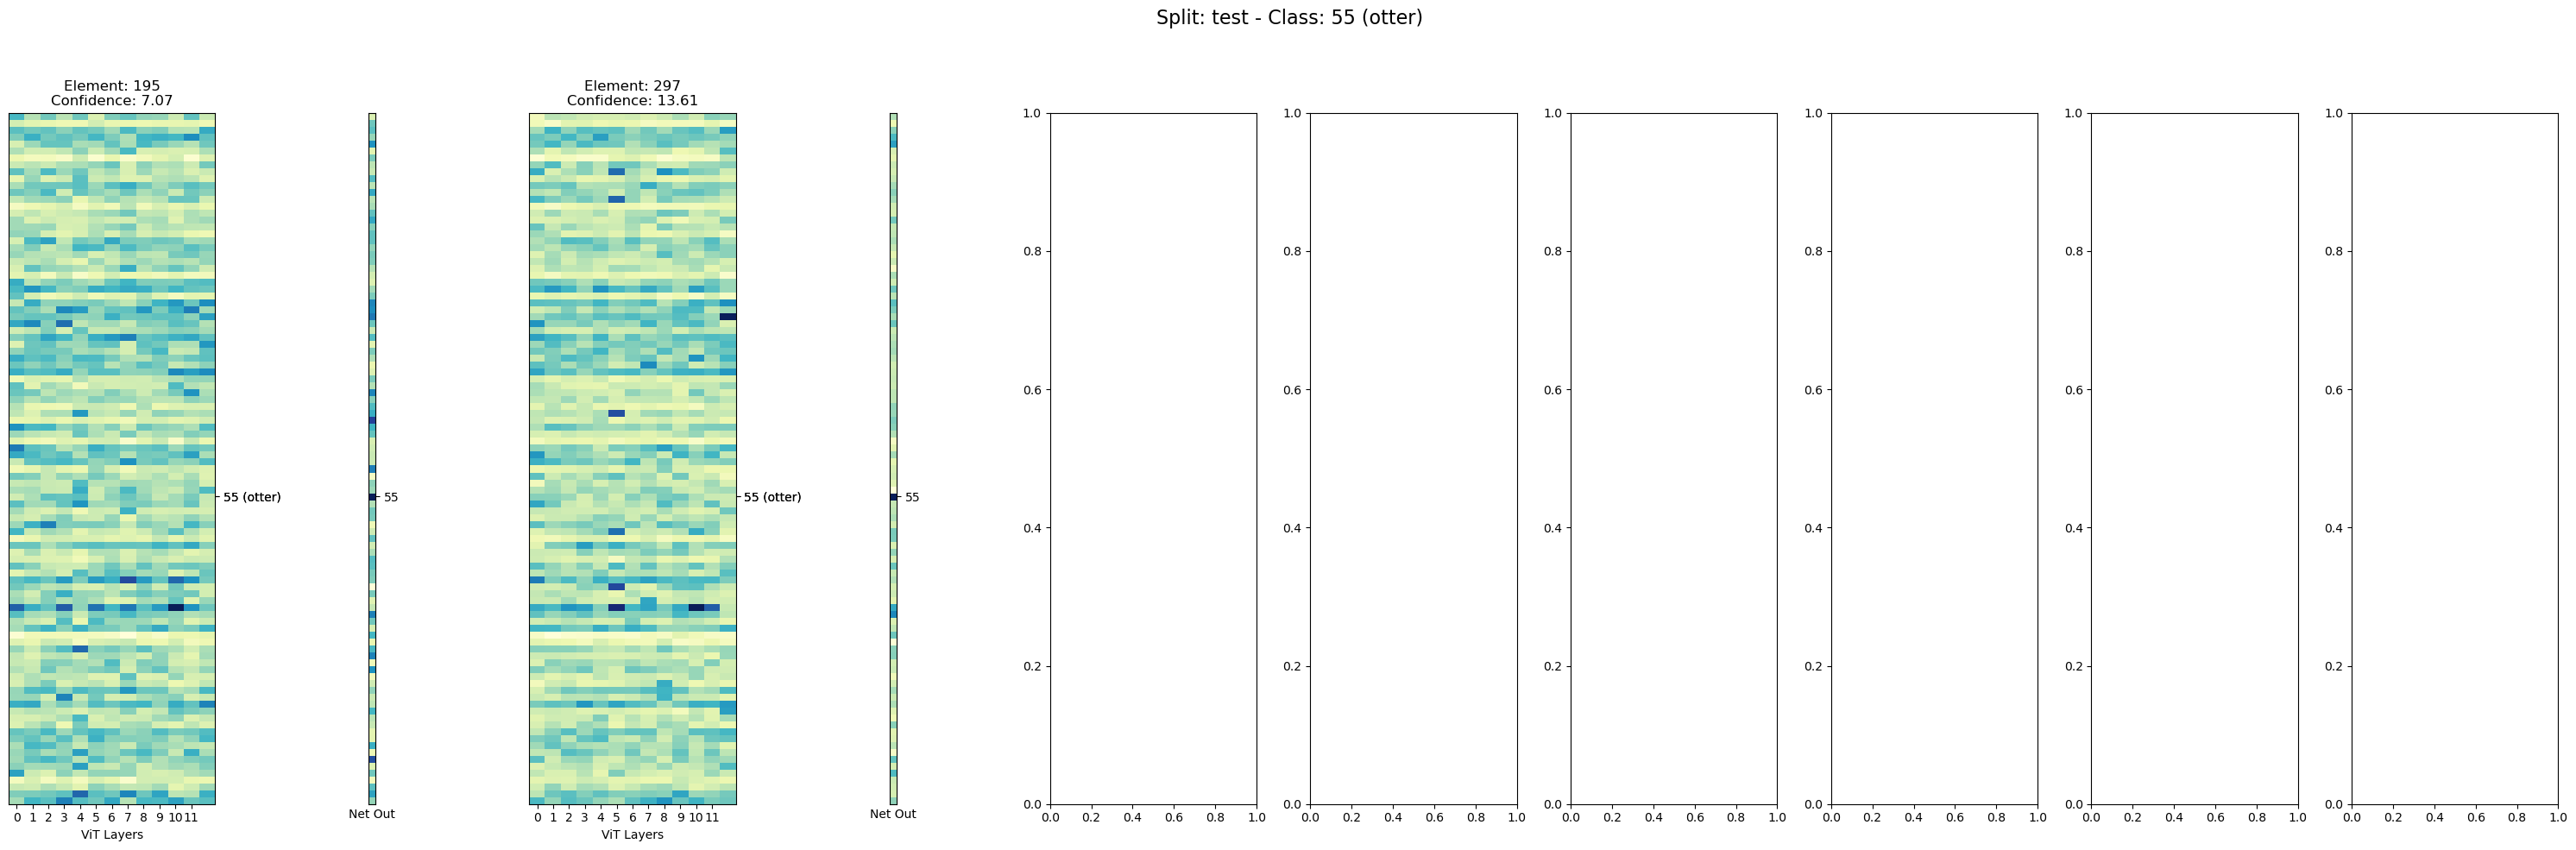

In [25]:
def generate_5_concepto_horiz(cifar_class, result, confidence):
    
    split = 'test'

    rand_samples = []
    k = 0
    while len(rand_samples) < 5 and k < 500:
        if o_dnn_dfs[split]['result'][k] == result and o_dnn_dfs[split]['true'][k] == cifar_class and o_dnn_dfs[split]['max'][k] >= confidence:
            rand_samples.append(k)
        k += 1

    print('Samples found: ', rand_samples)

    print('Chosen class:', ds._classes[cifar_class])

    fig, axes = plt.subplots(1, 10, figsize=(30, 10))  # 1 row and 10 columns (10 subplots in a row)

    for i, sample in enumerate(rand_samples):
        
        # labels
        true_out = o_dnn_dfs[split]['true'][sample] # number
        true_class = ds._classes[true_out]          # string

        label_out = o_dnn_dfs[split]['label'][sample]
        label_class = ds._classes[label_out]

        confidence = o_dnn_dfs[split]['max'][sample]

        # matrix and array (print pre label with soft max -> o_dnn)
        concepto = cgs_dict[split][sample].detach().cpu().numpy().T
        out_net = np.expand_dims(o_dnn[split][sample], axis=1)  # roba predetta

        # conceptogram plot (Odd indices: 0, 2, 4, 6, 8)
        ax_concepto = axes[i * 2]
        ax_concepto.imshow(concepto, aspect='auto', cmap='YlGnBu')
        ax_concepto.set_xticks(np.arange(12))
        ax_concepto.set_yticks([true_out, label_out], [f'{true_out} ({true_class})', f'{label_out} ({label_class})'])
        ax_concepto.yaxis.tick_right()
        ax_concepto.set_xlabel('ViT Layers')
        ax_concepto.set_title(f'Element: {sample}\nConfidence: {confidence:.2f}')

        # net output plot (Even indices: 1, 3, 5, 7, 9)
        ax_out_net = axes[i * 2 + 1]
        ax_out_net.imshow(out_net, cmap='YlGnBu')
        ax_out_net.set_xticks([])
        ax_out_net.set_yticks([true_out])
        ax_out_net.yaxis.set_label_position("right")
        ax_out_net.yaxis.tick_right()
        ax_out_net.set_xlabel('Net Out')

    # global title
    fig.suptitle(f'Split: {split} - Class: {cifar_class} ({ds._classes[cifar_class]})', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()




cifar_class = 55
result = 1
confidence = 0.01

print(ds._classes[cifar_class])

generate_5_concepto_horiz(cifar_class, result, confidence)